In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model, fit_report

Populating the interactive namespace from numpy and matplotlib


In [2]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def line(x, a, b):
    return a*x+b

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner4(x, M, w,  G1):
    a = M/(2*np.pi*G1)
    b = 1 + np.square(2*(x-w)/G1)
    return np.round(a/b, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def QFC_back4(x, E_qf, N_0, Q_EC, S_p, E_projectile):
    W = 22
    T = 100
    E_t_gs = E_projectile - Q_EC
    E_0 = E_t_gs - S_p
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [3]:
data_to_fit_x = np.linspace(0,25, 4000)

## data from 1999

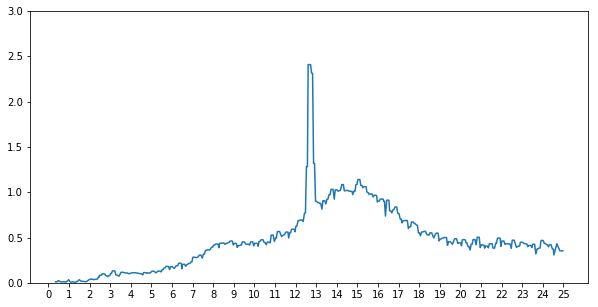

In [4]:
data1985 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_fig2.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
#data1985['x'] = -data1985['x'] + 120

plt.figure(figsize=(10,5))
plt.plot(data1985['x'].values, data1985['y'].values)
plt.xticks(np.arange(0,26,1))
plt.ylim(0,3)
plt.show()

In [7]:
total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3, prefix='pigmy2_') \
+Model(breit_vigner3, prefix='IAS_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(QFC_back4, prefix='QFC_')

total_mod.set_param_hint('pigmy1_w', value=9, min=5, max=11)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

total_mod.set_param_hint('pigmy2_w', value=4, min=0.1, max=6)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=3)
total_mod.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

total_mod.set_param_hint('IAS_w', value=13.5, min=12, max=14)
total_mod.set_param_hint('IAS_G1', value=0.1, min=0.01, max=3)
total_mod.set_param_hint('IAS_M', value=1, min=0.1, max=20)

total_mod.set_param_hint('GTR_w', value=15, min=11, max=16)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

total_mod.set_param_hint('QFC_E_qf', value=400, min=50, max=420)
total_mod.set_param_hint('QFC_N_0', value=8, min=1, max=15)
total_mod.set_param_hint('QFC_Q_EC', value=0.662, vary=False)
total_mod.set_param_hint('QFC_S_p', value=7.699, vary=False)
total_mod.set_param_hint('QFC_E_projectile', value=159.1, vary=False)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data1985['y'].values, pars, x=data1985['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='IAS_')) + Model(breit_vigner3, prefix='GTR_')) + Model(QFC_back4, prefix='QFC_'))
[[Fit Statistics]]
    # function evals   = 34156
    # data points      = 449
    # variables        = 14
    chi-square         = 1.495
    reduced chi-square = 0.003
    Akaike info crit   = -2533.626
    Bayesian info crit = -2476.128
[[Variables]]
    pigmy1_M:           0.41487218 (init= 5)
    pigmy1_w:           8.59865810 (init= 9)
    pigmy1_G1:          1.49980329 (init= 0.1)
    pigmy2_M:           0.21304837 (init= 1)
    pigmy2_w:           0.53485665 (init= 4)
    pigmy2_G1:          2.63455792 (init= 0.1)
    IAS_M:              0.24586788 (init= 1)
    IAS_w:              12.7132478 (init= 13.5)
    IAS_G1:             0.12321887 (init= 0.1)
    GTR_M:              2.58599206 (init= 5)
    GTR_w:              14.8689094 (init= 15)
    GTR_G1:             2.8159

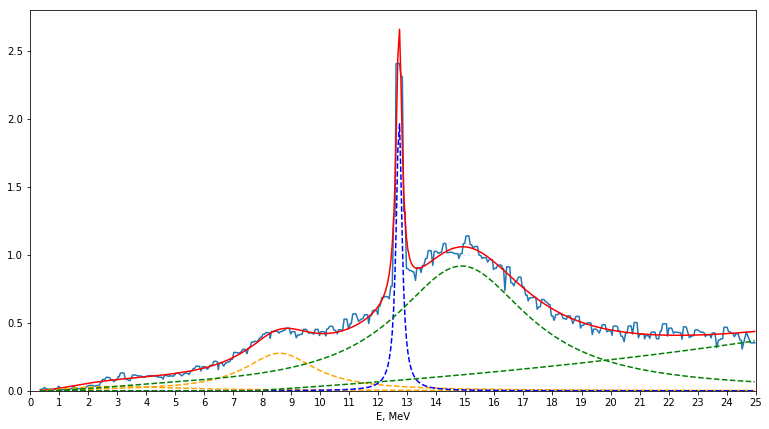

In [8]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data1985['x'].values, data1985['y'].values, label='experimental data')
plt.plot(data1985['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data1985['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data1985['x'].values, total_mod_comps['pigmy2_'], 'orange', label='pigmy2', ls='--')
plt.plot(data1985['x'].values, total_mod_comps['IAS_'], 'b--', label='IAS')
plt.plot(data1985['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data1985['x'].values, total_mod_comps['QFC_'], 'g--', label='QFC')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,2.8)
plt.xlim(0,25)
plt.xticks(np.arange(0,26,1))
plt.show()

In [9]:
total_mod_gauss = Model(gauss,prefix='pigmy1_') \
+Model(gauss, prefix='pigmy2_') \
+Model(gauss, prefix='IAS_') \
+Model(gauss, prefix='GTR_') \
+Model(QFC_back4, prefix='QFC_')

total_mod_gauss.set_param_hint('pigmy1_mu', value=9, min=5, max=11)
total_mod_gauss.set_param_hint('pigmy1_sigma', value=0.1, min=0.1, max=3)
total_mod_gauss.set_param_hint('pigmy1_k', value=5, min=0.1, max=10)

total_mod_gauss.set_param_hint('pigmy2_mu', value=4, min=0.1, max=6)
total_mod_gauss.set_param_hint('pigmy2_sigma', value=0.1, min=0.1, max=1.0)
total_mod_gauss.set_param_hint('pigmy2_k', value=1, min=0.1, max=2)

total_mod_gauss.set_param_hint('IAS_mu', value=13.5, min=12, max=14)
total_mod_gauss.set_param_hint('IAS_sigma', value=0.1, min=0.01, max=3)
total_mod_gauss.set_param_hint('IAS_k', value=1, min=0.1, max=10)

total_mod_gauss.set_param_hint('GTR_mu', value=15, min=11, max=16)
total_mod_gauss.set_param_hint('GTR_sigma', value=2, min=2, max=5)
total_mod_gauss.set_param_hint('GTR_k', value=5, min=0.1, max= 30)

total_mod_gauss.set_param_hint('QFC_E_qf', value=400, min=50, max=420)
total_mod_gauss.set_param_hint('QFC_N_0', value=8, min=1, max=10)
total_mod_gauss.set_param_hint('QFC_Q_EC', value=0.662, vary=False)
total_mod_gauss.set_param_hint('QFC_S_p', value=7.699, vary=False)
total_mod_gauss.set_param_hint('QFC_E_projectile', value=159.1, vary=False)

pars_gauss = total_mod_gauss.make_params()

total_mod_gauss_result = total_mod_gauss.fit(data1985['y'].values, pars_gauss, x=data1985['x'].values, 
                                 method='differential_evolution')

print(total_mod_gauss_result.fit_report())

[[Model]]
    ((((Model(gauss, prefix='pigmy1_') + Model(gauss, prefix='pigmy2_')) + Model(gauss, prefix='IAS_')) + Model(gauss, prefix='GTR_')) + Model(QFC_back4, prefix='QFC_'))
[[Fit Statistics]]
    # function evals   = 57766
    # data points      = 449
    # variables        = 14
    chi-square         = 1.047
    reduced chi-square = 0.002
    Akaike info crit   = -2693.425
    Bayesian info crit = -2635.927
[[Variables]]
    pigmy1_mu:          8.39519684 (init= 9)
    pigmy1_sigma:       1.83484369 (init= 0.1)
    pigmy1_k:           0.36334216 (init= 5)
    pigmy2_mu:          3.58384525 (init= 4)
    pigmy2_sigma:       1          (init= 0.1)
    pigmy2_k:           0.10764885 (init= 1)
    IAS_mu:             12.7157218 (init= 13.5)
    IAS_sigma:          0.11628070 (init= 0.1)
    IAS_k:              1.83247817 (init= 1)
    GTR_mu:             14.6100823 (init= 15)
    GTR_sigma:          2.16296839 (init= 2)
    GTR_k:              0.75924317 (init= 5)
    QFC_E_qf:    

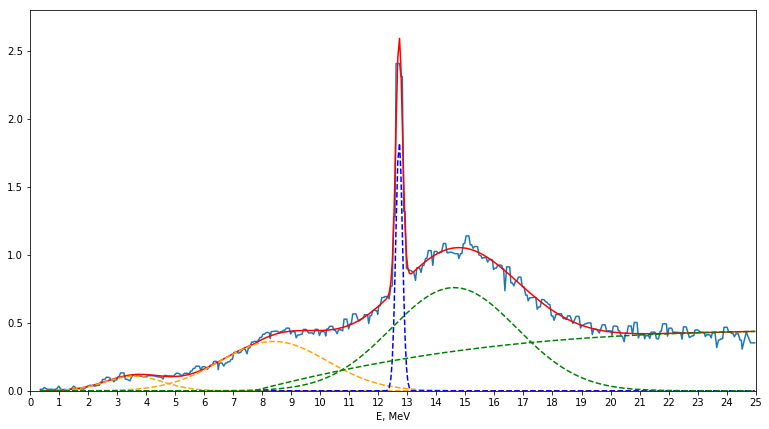

In [10]:
total_mod_gauss_comps = total_mod_gauss_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data1985['x'].values, data1985['y'].values, label='experimental data')
plt.plot(data1985['x'].values, total_mod_gauss_result.best_fit, 'r-', label='total fit')
plt.plot(data1985['x'].values, total_mod_gauss_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data1985['x'].values, total_mod_gauss_comps['pigmy2_'], 'orange', label='pigmy2', ls='--')
plt.plot(data1985['x'].values, total_mod_gauss_comps['IAS_'], 'b--', label='IAS')
plt.plot(data1985['x'].values, total_mod_gauss_comps['GTR_'], 'g--', label='GTR')
plt.plot(data1985['x'].values, total_mod_gauss_comps['QFC_'], 'g--', label='QFC')
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,2.8)
plt.xlim(0,25)
plt.xticks(np.arange(0,26,1))
plt.show()

In [11]:
output = pd.DataFrame(data={'Ex, MeV':data1985['x'].values,
                            'y':total_mod_gauss_comps['pigmy1_']+
                           total_mod_gauss_comps['pigmy2_']+
                           total_mod_gauss_comps['GTR_']})
output.head()

,"Ex, MeV",y
0,0.350987,0.000603
1,0.434621,0.000786
2,0.482412,0.000911
3,0.589942,0.001261
4,0.733315,0.001911


In [14]:
output.to_excel('127Xe_gauss.xls', index=False)

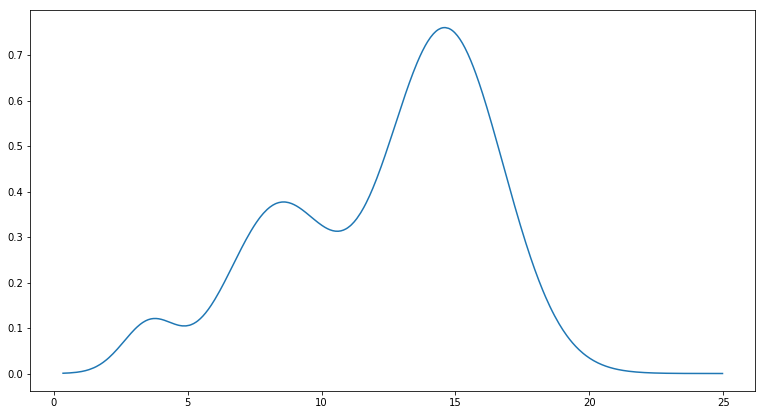

In [13]:
plt.figure(figsize=(13,7))
plt.plot(output['Ex, MeV'].values, output['y'].values)
plt.show()

In [17]:
10e01

100.0